# Hypothesis testing for two binomials distributions

Hypothesis testing for a [binomial proportion](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval) is a well-studied problem and most statistical libraries have built-in [solutions](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportion_confint.html) for generating confidence intervals (CIs) and p-values. Testing the *difference* between two binomial proportions is a similar statistical problem, but there are fewer available methods. In my experience, most statistical handbooks recommend using normal approximations or contingency tables when there are two sets of binary outcomes to be compared. Unfortunately these approaches have drawbacks. Normal approximations based on asymptotic theory have noticeably poor coverage when sample sizes are small or the probability of an event is close to zero or one. [Fisher's Exact test](https://en.wikipedia.org/wiki/Fisher%27s_exact_test) is undoubtedly a powerful contingency table method for obtaining p-values under the null of no difference. However it is hard to use for power calculations, and when the outcome space is large it requires Monte Carlo approximations. The idea of using an *exact* distribution of the difference in two binomial proportions is not a new one (see [here](https://www.jstor.org/stable/2533740?seq=1) or [here](https://arxiv.org/pdf/1903.03327.pdf)). "Exact" testing refers to using actual quantiles of the test statistic's distribution, rather than approximations, under the null. Using exact inference techniques for the difference between binomial distributions is almost never used, and, as far as I know, not supported in languages like `python`. 

In this post I want to provide researchers with the tools necessary to carry out hypothesis testing for the difference between two binomial distributions. I will also highlight the main statistical challenge inherent in the inference of the problem: when the null proportion is not known before the sampling. By the end of the post, I will provide:  

1. Functions to calculate the PMF and CDF for the distribution of a difference between binomials
2. Functions to generate quantiles for this distribution at any nominal level
3. A proof that the type-I errors are unknowably conservative when the null proportion needs to be estimated.

Note that if the null proportion is known before testing, then the type-I errors will be conservative, but *knowably* so, since the difference between the targeted and actual levels will be determined by the discrete nature of the CDF. However, when the null proportion itself needs to be estimated, I will show that the type-I errors will be more conservative than what is suggested by the CDF derived from the empirical null proportion. 

## (1) Review: Exact inference for a single binomial distribution

This first section will review the binomial distribution, establish notation, and show that it has exact and knowably-conservative type-I errors for hypothesis testing. The binomial distribution, $y \sim B(n,\pi)$, is parameterized by the number of trials ($n$) and the probability of a positive outcome ($\pi$), where $E(y)=n\pi$. As there are many ways to have $k$ successes, the PMF of this discrete distribution uses the [binomial coefficient](https://en.wikipedia.org/wiki/Binomial_coefficient) to capture these *combinations*:

$$
\begin{align*}
f_{\pi,n}(k) &= P(y = k) = \begin{pmatrix} n \\ k \end{pmatrix} \pi^k (1-\pi)^{1-k} \\
F_{\pi,n}(k) &= P(y \leq k) = \sum_{j=0}^k f_{\pi,n}(j)
\end{align*}
$$

The binomial distribution can represent a number of useful processes we may want to carry out inference on such as the frequency of credit defaults, the sensitivity of a test, or the precision of a classier. All of these processes  count the number of times a binary event happens out of a total number of trials. Hypothesis testing for a binomial random variable is therefore to reject (or not) some claim about the underlying proportion $\pi$, since this is the parameter that defines the distribution ($n$ obviously being known). For example if we wanted to test whether a medical test had a sensitivity of greater than 90% we would want to reject the following null:

$$
\begin{align*}
H_0:& \pi \leq 0.9 \\
H_A:& \pi > 0.9
\end{align*}
$$

The test statistic $\hat\pi=y/n$ is the obvious choice to estimate this quantity since it is the  minimum-variance unbiased estimator (MVUE) of $\pi$. A two-sided hypothesis test partitions the space of observable test statistic values into a rejection and acceptance region. A hypothesis test that of the $1-\alpha$ level should have an acceptance region with the following properties:

$$
\begin{align*}
P(\hat\pi \in [l, u]| H_0) \geq 1-\alpha \hspace{1mm},
\end{align*}
$$

Where $\alpha$ is the type-I error rate. In other words, the probability that the parameter of interest falls outside this interval occurs *at most* $\alpha$% of the time, **when the null is true**. To be clear, the interval $[l,u]$ is not a confidence interval,[[^1]] it is the acceptance region. This requirement to be conservative means the choice of quantile needs to be similarly conservative with respect to the CDF. A one-sided hypothesis test is equivalent to setting either $u$ or $l$ as equal to $\pm \infty$.

For example, consider the distribution of 20 fair coin flips where the probability that 13 or fewer heads will occur is 94%, whereas 14 or fewer heads occurring is 98%. If one needed to pick an upper bound (assume a one-sided test) so that the number of times the null of $\pi\leq 0.5$ was rejected was *at most* 5%, then one would have to the interval $[0,14]$, even though the type-I error rate would actually only be 2% rather than the desired 5%.  

$$
\begin{align}
k_{\alpha}^* &= F_{\pi,n}^{-1}(\alpha) = \begin{cases} \inf_k \hspace{2mm} \{ k: F_{\pi,n}(k) \geq \alpha \} &\text{if}& \alpha \geq 0.5  \\ \sup_k \{ k: F_{\pi,n}(k) \leq \alpha \} + 1 &\text{if}& \alpha < 0.5  \end{cases} \label{eq:thresh_binom}
\end{align}
$$

Equation \eqref{eq:thresh_binom} shows how to conservatively invert the CDF if the binomial distribution so that intervals formed by $[k_{\alpha}^*, k_{1-\alpha}^*]$ obtain create a acceptance region with a type-I error or at most $2\alpha$.[[^2]] But since the test statistic is $y/n$ and not $y$, it is easy enough to see how the upper and lower bounds are to be constructed:

$$
\begin{align*}
l, u &= \Bigg( \frac{k_{\alpha/2}}{n}, \frac{k_{1-\alpha/2}}{n} \Bigg) 
\end{align*}
$$

Note that $(l,u)$ are implicitly functions of $\pi$ and $n$. The rejection region (the space where the null hypothesis is rejected) is also easily defined:

$$
\begin{align*}
\text{Reject } H_0 &= \big\{ \hat\pi < n^{-1}k_{\alpha/2}^*, \hspace{2mm} \hat\pi > n^{-1}k_{1-\alpha/2} \big\}
\end{align*}
$$

Where $\pi$ is the proportion under the null. The first code block below defines the function `qbinom` which implements \eqref{eq:thresh_binom} and shows whether the type-I errors are conservative and if the discrepancy between the predicted and actual type-I error rates can be made for the 90% level.

[^1]: This definition of a confidence interval has been in use since Jerzy Neyman's definition of it in a classic 1937 [paper](https://royalsocietypublishing.org/doi/pdf/10.1098/rsta.1937.0005).

[^2]: You may be curious why I am adding 1 to the lower bound critical value but not the upper bound. The reason for this is simple, but a bit technical. Recall that $F_{0.5,20}(5)=0.02$ and $F_{0.5,20}(6)=0.06$, so that $k_{0.05}^{*}=5$. But if $P(y\leq 5)=0.02$, then $P(y \geq 6)=0.98$, because the distribution is discrete. In other words, the bound we want for $l$ is 6 and not 5, since $P(y\leq 5) \neq P(y \geq 5)$. 

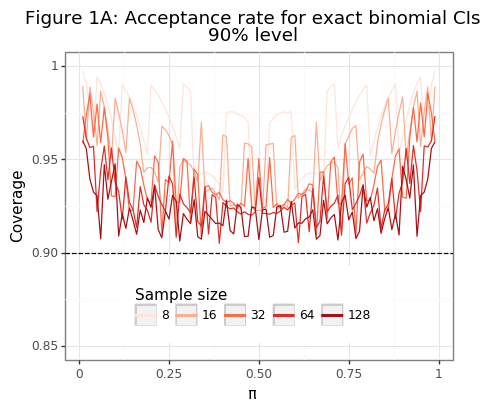

<ggplot: (8734085957657)>


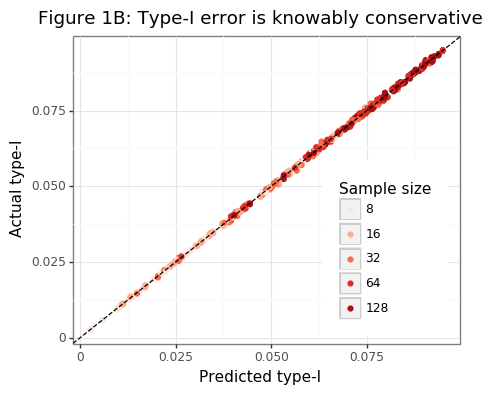

<ggplot: (8734073092341)>


In [1]:
import warnings
import numpy as np
import pandas as pd
import plotnine
from plotnine import *
from scipy.stats import norm, binom

# Function to calculate t*_alpha
def qbinom(alpha, n, pi):
    assert (alpha >= 0) & (alpha <= 1)
    kstar = int(binom.ppf(q=alpha,n=n,p=pi)) # Use first quantile estimate
    Fk = binom.cdf(k=kstar,n=n,p=pi) # Calculate p-value
    check = bool(np.where(alpha>0.5, Fk>=alpha, Fk<=alpha))
    while not check:
        kstar = int(np.where(alpha>0.5, kstar+1, kstar-1))
        Fk = binom.cdf(k=kstar,n=n,p=pi)
        check = bool(np.where(alpha>0.5, Fk>=alpha, Fk<=alpha))
    return kstar


np.random.seed(1234)
nsim = 250000
alpha = 0.1
pi_seq = np.round(np.arange(0.01,1,0.01),2)
n_seq = 2**np.arange(3,8,1)
decimals = 12 # Getting float point issues otherwise

holder = []
for pi in pi_seq:
    for n in n_seq:
        # Establish the lower/upper quantile bounds
        ku = qbinom(alpha=1-alpha/2, n=n, pi=pi)
        kl = 1 + qbinom(alpha=alpha/2, n=n, pi=pi)
        # Draw data under the null
        khat = np.random.binomial(n, pi, size=nsim)
        phat = khat / n
        # Calculate the CIs under the null
        l = phat - (ku/n - pi)
        u = phat + (pi-kl/n)
        coverage = np.mean((pi >= np.round(l,decimals)) & (pi <= np.round(u,decimals)))
        # Calculate the expected coverage
        t1_u = 1-binom.cdf(k=ku,n=n,p=pi)
        t1_l = binom.cdf(k=kl-1,n=n,p=pi)
        t1e = t1_u + t1_l
        tmp = pd.DataFrame({'pi':pi,'n':n,'coverage':coverage,'expected':t1e},index=[0])
        holder.append(tmp)
sim_exact = pd.concat(holder).reset_index(None,True).assign(n=lambda x: pd.Categorical(x.n, x.n.unique()),actual=lambda x: 1-x.coverage)
# Make plots
plotnine.options.figure_size = (5, 4)
gg_cov_exact = (ggplot(sim_exact, aes(x='pi',y='coverage',color='n'))+
               theme_bw() + geom_line() + 
               labs(x='π',y='Coverage') + 
               ggtitle('Figure 1A: Acceptance rate for exact binomial CIs\n90% level') + 
               theme(legend_position=(0.5,0.25),legend_direction='horizontal') + 
               scale_y_continuous(limits=[0.85,1.0],breaks=list(np.arange(0.85,1.01,0.05))) + 
               geom_hline(yintercept=0.90,linetype='--') + 
               scale_color_brewer(name='Sample size', palette='Reds'))
print(gg_cov_exact)
plotnine.options.figure_size = (5, 4)
gg_t1_exp = (ggplot(sim_exact, aes(x='expected',y='actual',color='n'))+
               theme_bw() + geom_point() + 
               labs(x='Predicted type-I',y='Actual type-I') + 
               ggtitle('Figure 1B: Type-I error is knowably conservative') + 
               scale_color_brewer(name='Sample size', palette='Reds') + 
             geom_abline(slope=1,intercept=0,linetype='--') + 
             theme(legend_position=(0.75,0.35)))
print(gg_t1_exp)

Figure 1A demonstrates how we can obtain a conservative type-I error for the binomial distribution. Keep in mind that in the case where $\pi$ is close to 0 or 1, and $n$ is small, the type-I error may amount to 0% at the 90% level! Though we will  discuss power calculations for these tests, it is clear that no sample size will be sufficient to reject the null in this case. For example if $n=8$ and $\pi=0.7$, then $F(7)=0.94$ and $F(8)=1.0$, so the null will never be rejected a value of $\hat \pi > u$. Ironically "exact" tests can be quite inexact!  Yet it is arguable whether hypothesis testing should occur for such small sample sizes anyways. Figure 1B shows the conservatism of the type-I error can be perfectly predicted. Such knowable discrepancies are useful when performing power calculations under some alternative $\pi$.

## (2) Defining the distribution for two binomials

Suppose there are two binomial distributions $y_1 \sim B(\pi_1, n_1)$ and $y_2 \sim B(\pi_2, n_2)$, then one may want to ask whether the difference between their proportions is zero $\Delta_\pi=\pi_1 - \pi_2=0$? There are all sorts of processes where a researcher would want to know whether two binomial distributions differed. For example one could compare the proportion of negative side-effects between two drug trial arms, or the proportion of economic quarters spent in recession between two countries. In most real-word cases, the hypothesis of interest is whether $\pi_1=\pi_2$, with variations in $n_1$ and $n_2$ occurring naturally from differences in the observation process.[[^3]] There may be situations where $\pi_i$ is already known for one or both groups and one simply wants to examine the likelihood of such data being generated under this null hypothesis. Because the realizations of $y_1$ and $y_2$ are independent, one can calculate the PMF by taking the outer product of the respective PMFs.  More formally, we can define the PMF and CDF as follows:

$$
\begin{align*}
f_{\Delta}(k_1, k_2;\mathbf{n}, \mathbf{\pi}) &=  f_{\pi_1,n_1}(k_1) \cdot f_{\pi_2,n_2}(k_2) \\
F_{\Delta}(k_1, k_2; \mathbf{n}, \mathbf{\pi}) &= P(y_1\leq k_1, y_1\leq k_2 ) \\
&= \sum_{j_1=0}^{k_1} \sum_{j_2=0}^{k_2} f_\Delta(j_1, j_2;\mathbf{n}, \mathbf{\pi}) \\
&= F_{\pi_1,n_1}(j_1) \cdot F_{\pi_2,n_2}(j_2), \hspace{5mm} \text{by independence}
\end{align*}
$$

In the code block below we will define a class `dist_binom2` which can calculate the PMF and CDF of any $(y_1,y_2)$ pair as well as pre-calculating these values for the support of the distribution.


[^3]: In the case of comparing the economic performance between two countries, the number of years that GDP has been recorded will likely differ. 

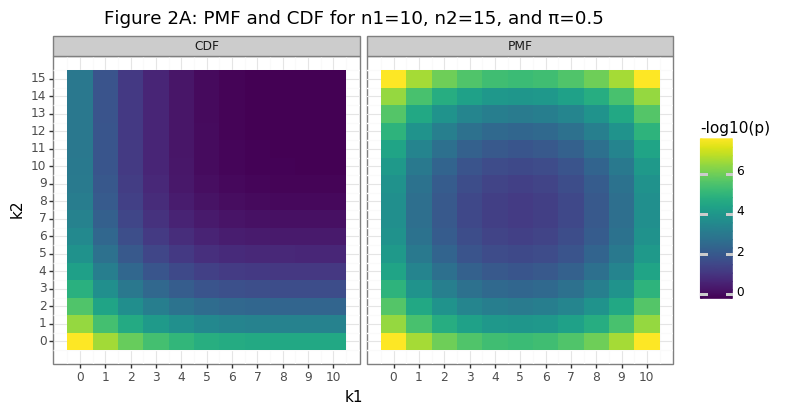

<ggplot: (8734073092069)>

In [2]:
class dist_binom2():
    def __init__(self, n1, pi1, n2, pi2):
        check1 = (n1 >= 0) & (n2 >= 0) & (isinstance(n1,int)) & (isinstance(n1,int))
        assert check1
        check2 = (pi1 >= 0) & (pi1 <= 1) & (pi2 >= 0) & (pi2 <= 1)
        assert check2
        r1, r2 = range(n1+1), range(n2+1)
        self.n1, self.pi1, self.n2, self.pi2 = n1, pi1, n2, pi2
        pmf1 = np.array([binom.pmf(k=k,n=n1,p=pi1) for k in r1])
        pmf2 = np.array([binom.pmf(k=k,n=n2,p=pi2) for k in r2])
        cdf1 = np.array([binom.cdf(k=k,n=n1,p=pi1) for k in r1])
        cdf2 = np.array([binom.cdf(k=k,n=n2,p=pi2) for k in r2])
        mat_pmf = pd.DataFrame(np.outer(pmf2, pmf1)).rename_axis('v2').reset_index()
        mat_cdf = pd.DataFrame(np.outer(cdf2, cdf1)).rename_axis('v2').reset_index()
        self.mat_dist = mat_pmf.melt('v2',None,'v1','pmf').merge(mat_cdf.melt('v2',None,'v1','cdf'),'left',['v2','v1'])
        self.mat_dist[['v1','v2']] = self.mat_dist[['v1','v2']].astype(int)
        self.mat_dist = self.mat_dist.sort_values('pmf').reset_index(None,True)
        idx_dist = self.mat_dist.groupby(['pmf']).pmf.sum().rename_axis('idx').reset_index()
        idx_dist = idx_dist.assign(pval=lambda x: x.pmf.cumsum()).drop(columns='pmf').rename(columns={'idx':'pmf'})
        self.mat_dist = self.mat_dist.merge(idx_dist,'left','pmf')
        
        self.mat_dist = self.mat_dist.assign(pval=lambda x: x.pmf.cumsum())

    def cdf(self,y1,y2):
        assert (y1>=0) & (y1<=self.n1) & (y2>=0) & (y2<=self.n2)
        return binom.cdf(k=y1,n=self.n1,p=self.pi1) * binom.cdf(k=y2,n=self.n2,p=self.pi2)
    
    def pmf(self,y1,y2):
        assert (y1>=0) & (y1<=self.n1) & (y2>=0) & (y2<=self.n2)
        return binom.pmf(k=y1,n=self.n1,p=self.pi1) * binom.pmf(k=y2,n=self.n2,p=self.pi2)

n1, n2 = 10, 15
pi1, pi2 = 0.5, 0.5
dist = dist_binom2(n1=n1, pi1=pi1, n2=n2, pi2=pi2)
mat_dist = dist.mat_dist.copy().drop(columns='pval')
# mat_dist = mat_dist.assign(pval=2*np.min(np.c_[mat_dist.cdf,1-mat_dist.cdf],1)).assign(pval=lambda x: np.where(x.pval==0,1e-10,x.pval))
mat_dist = mat_dist.melt(['v1','v2'],None,'tt')
plotnine.options.figure_size = (8, 4)
gg_outer = (ggplot(mat_dist,aes(x='v1',y='v2',fill='-np.log10(value)')) + theme_bw() + 
            geom_tile() + guides(color=False) + labs(x='k1',y='k2') + 
            facet_wrap('~tt',labeller=labeller(tt={'cdf':'CDF','pmf':'PMF','pval':'P-value'})) + 
            ggtitle('Figure 2A: PMF and CDF for n1=10, n2=15, and π=0.5') + 
            scale_x_continuous(breaks=list(range(n1+1))) + 
            scale_y_continuous(breaks=list(range(n2+1))) + 
            scale_fill_continuous(name='-log10(p)'))
gg_outer

### CHECK THAT FISHER AND EXACT ARE EQUALLY CONSERVATIVE

/home/edrysdale/miniconda3/lib/python3.7/site-packages/pyranges/statistics.py:163: RuntimeWarning: divide by zero encountered in true_divide


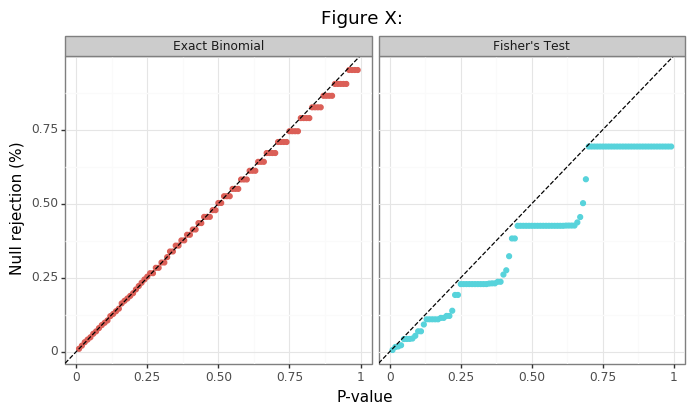

<ggplot: (8734066208881)>

In [74]:
n1, n2 = 10, 15
pi1, pi2 = 0.5, 0.5
dist = dist_binom2(n1=n1, pi1=pi1, n2=n2, pi2=pi2)

# Do a simulation
from scipy.stats import fisher_exact as fisher_exact_sp
from pyranges.statistics import fisher_exact as fisher_exact_py
nsim = 15000
np.random.seed(1234)
y1, y2 = np.random.binomial(n1, pi1, nsim), np.random.binomial(n2, pi2, nsim)
df_sim = pd.DataFrame({'y1':y1,'f1':n1-y1, 'y2':y2, 'f2':n2-y2})
pval_fisher = fisher_exact_py(df_sim.y1, df_sim.f1, df_sim.y2, df_sim.f2).P
df_sim = df_sim.rename(columns={'y1':'v1','y2':'v2'}).drop(columns=['f1','f2'])
pval_exact = df_sim.merge(dist.mat_dist.drop(columns=['pmf','cdf'])).pval
p_seq = np.arange(0.01,1,0.01)
t1_fisher = [np.mean(pval_fisher <= p) for p in p_seq]
t1_exact = [np.mean(pval_exact <= p) for p in p_seq]
df_t1_comp = pd.DataFrame({'p':p_seq,'fisher':t1_fisher, 'exact':t1_exact}).melt('p',None,'tt')
plotnine.options.figure_size = (8, 4)
gg_t1_comp = (ggplot(df_t1_comp, aes(x='p',y='value',color='tt')) + theme_bw() + geom_point() + 
              facet_wrap('~tt',labeller=labeller(tt={'exact':'Exact Binomial','fisher':"Fisher's Test"})) + 
              geom_abline(slope=1,intercept=0,color='black',linetype='--') + 
              guides(color=False) + labs(x='P-value',y='Null rejection (%)') + 
              ggtitle('Figure X: '))
gg_t1_comp

### VARY PI2 AND COMPARE POWER

In [178]:
n1, n2, pi1 = 10, 15, 0.5
pi2_null = 0.5
dist_null = dist_binom2(n1=n1, pi1=pi1, n2=n2, pi2=pi2_null)

holder = []
for p in p_seq:
    tmp_dist = dist_binom2(n1=n1, pi1=p, n2=n2, pi2=p)
    holder.append(tmp_dist.mat_dist.assign(p=p))
dist_emp = pd.concat(holder).reset_index(None,True)

pi2_seq = np.round(np.arange(pi2_null,0.24,-0.01),2)
pi2_seq = np.round(np.arange(pi2_null,0.76,0.01),2)
nsim = 15000
np.random.seed(nsim)

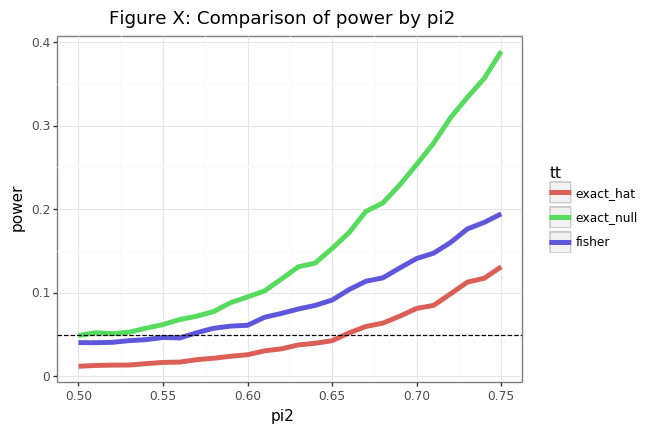

<ggplot: (8734056403517)>

In [228]:
di_cn = {'P':'fisher_both','PLeft':'fisher_left', 'PRight':'fisher_right'}
holder = []
for pi2 in pi2_seq:
    y1, y2 = np.random.binomial(n1, pi1, nsim), np.random.binomial(n2, pi2, nsim)
    pi_hat = (y1+y2)/(n1+n2)
    df_sim = pd.DataFrame({'v1':y1,'f1':n1-y1, 'v2':y2, 'f2':n2-y2, 'p':pi_hat})
    pval_fisher = fisher_exact_py(df_sim.v1, df_sim.f1, df_sim.v2, df_sim.f2).P
    pval_exact_hat = df_sim.merge(dist_emp,'left',['v1','v2','p']).pval
    pval_exact_null = df_sim.merge(dist_null.mat_dist,'left',['v1','v2']).pval
    tmp = pd.DataFrame({'pi2':pi2, 'fisher':pval_fisher, 'exact_null':pval_exact_null, 'exact_hat':pval_exact_hat})
    holder.append(tmp)
res_sim = pd.concat(holder).melt('pi2',None,'tt')
res_power = res_sim.groupby(['pi2','tt']).apply(lambda x: np.mean(x.value<0.05)).reset_index().rename(columns={0:'power'})

plotnine.options.figure_size = (6, 4.5)
gg_power = (ggplot(res_power,aes(x='pi2',y='power',color='tt')) + theme_bw() + 
            geom_path(size=2) + geom_hline(yintercept=0.05, linetype='--') + 
            ggtitle('Figure X: Comparison of power by pi2'))
gg_power

Figure 2A shows that shows the PMF centered on the mean of the two binomials and is symmetric (since $\pi_1=\pi_2=0.5$). The multivariate CDF does have the "normal" properties we expect from a univariate CDF. For example, the sum of the densities for $F_\Delta(k_1,k_2)\approx 0.05$ does not equal 0.05! 

Next let's examine how different combinations of $\pi_1$ and $\pi_2$ shift the PMF and the corresponding "rejection" rejection at the 90% level (i.e. 10% type-I error).

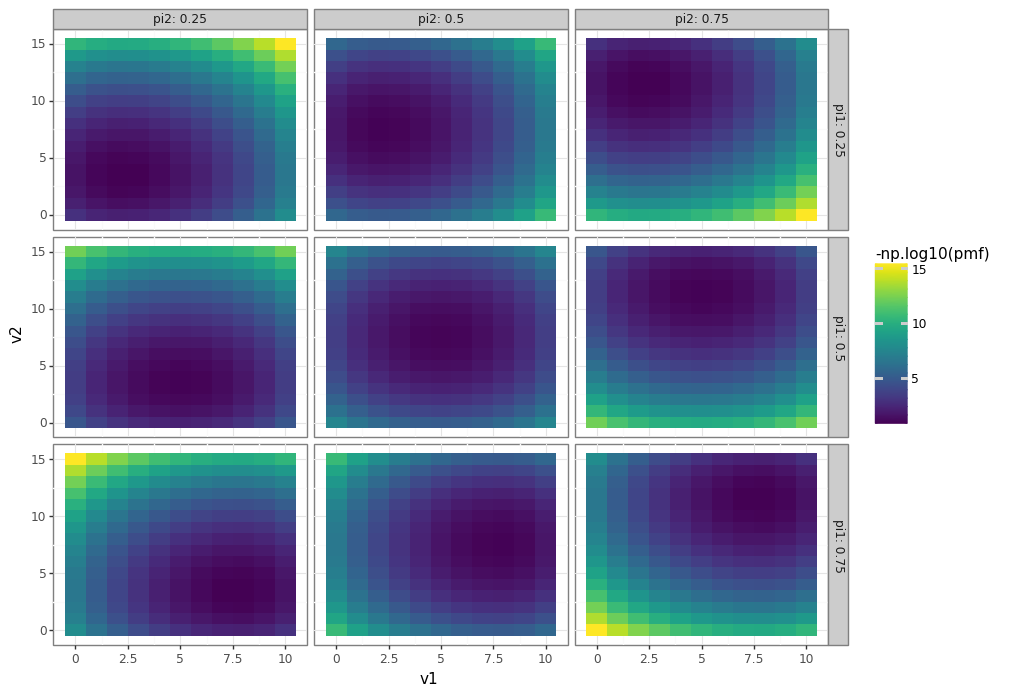

<ggplot: (8742736430785)>

In [88]:
n1, n2 = 10, 15
pi1_seq = [0.25, 0.5, 0.75] #[0.2, 0.4, 0.6, 0.8]
pi2_seq = pi1_seq

holder = []
for pi1 in pi1_seq:
    for pi2 in pi2_seq:
        dist = dist_binom2(n1=n1, pi1=pi1, n2=n2, pi2=pi2)
        dist.mat_dist = dist.mat_dist.assign(reject=lambda x: np.where(x.cdf<0.05,'x',np.where(x.cdf>0.95,'y','')))
        holder.append(dist.mat_dist.assign(pi1=pi1,pi2=pi2))
        del dist
df = pd.concat(holder)
df = df.assign(reject2=lambda x: np.where(x.reject=='',0,1),
               reject_l=lambda x: np.where(x.reject=='x',1,0),
               reject_u=lambda x: np.where(x.reject=='y',1,0))
plotnine.options.figure_size = (10, 8)
gg_comp = (ggplot(df, aes(x='v1',y='v2',fill='-np.log10(pmf)')) + theme_bw() + 
          geom_tile() + facet_grid('pi1~pi2',labeller=label_both)) #geom_text(aes(label='reject'),color='white')
gg_comp

As in Section 1, we will want to define a conservative rejection region to bound the type-I error rates.

$$
\begin{align}
(k_{1}^*(\alpha), k_{2}^*(\alpha)) &= \begin{cases} \{ (k_1, k_2): F_{\Delta}(k_1, k_2) \geq \alpha \} \text{ if } \alpha \geq 0.5 \\ \{ (k_1, k_2): F_{\Delta}(k_1, k_2) \leq \alpha \} \text{ if } \alpha < 0.5 \end{cases} \label{eq:thresh_binom}
\end{align}
$$

In other words, the rejection for two binomials is the set of pairs of successes that occur less than $1-\alpha$ percent of the time under the null of the distribution on the CDF. At this point you may be wondering why we haven't defined a new random variable, $d=y_1-y_2$, and used this as the basis for inference under the null. The problem is that hypothesis testing for a such a distribution is not identifiable because multiple configurations of $(\pi_1,\pi_2)$ can lead to the same moments of the distribution.

## (3) Hypothesis testing with $\pi_1$ and $\pi_2$ are known

When the proportions (and trial size) or both groups 1 and 2 are known, then exact CIs can be constructed similar to those of the single-group case in section (1). The population parameter of interest is now $\pi_1 - \pi_2=\Delta_\pi\in [-1,1]$, with the MVUE statistic being,

$$
\begin{align*}
\hat \Delta_\pi=\begin{cases}
y_1/n_1-y_2/n_2 &\text{if } \Delta_\pi\neq 0 \\
(y_1+y_2)/(n_1+n_2) &\text{if } \Delta_\pi= 0
\end{cases}
\end{align*}
$$

1. If $\pi_1=\pi_2$, this is easy
2. If $n_1=n_2$, ...
3. Problem of identifiability? Can we use simulataneous CIs for normal?
<!-- https://projecteuclid.org/download/pdf_1/euclid.aoms/1177728912 -->

In [74]:
np.random.seed(1234)
nsim = 100000
alpha = 0.10
pi1_seq = [0.4] # np.round(np.arange(0.1,1,0.1),2)
pi2_seq = [0.6]
n1_seq = [50] # [50, 100, 150]
n2_seq = [100] # n1_seq
nperm = len(pi_seq)*len(n1_seq)*len(n2_seq)
holder = []
count = 0
for pi1 in pi1_seq:
    for pi2 in pi2_seq:
        for n1 in n1_seq:
            for n2 in n2_seq:
                # Generate the data and statistics
                n_tot = (n1+n2)
                y1 = np.random.binomial(n1, pi1, nsim)
                y2 = np.random.binomial(n2, pi2, nsim)
                delta = y1 - y2
                if pi1 == pi2:
                    Dpi_hat = (y1+y2)/n_tot
                else:
                    Dpi_hat = y1/n1 - y2/n2
                

In [77]:
# Generate quantile bounds/CIs
Dpi_0 = np.round((pi1-pi2),2)
dist_dbinom = binom_diff(n1, pi1, n2, pi2)
dl, du = dist_dbinom.qdf(alpha/2), dist_dbinom.qdf(1-alpha/2)
l = phat - (du/n - pi)
u = phat + (pi-kl/n)
coverage = np.mean((pi >= np.round(l,decimals)) & (pi <= np.round(u,decimals)))
# Calculate the expected coverage
t1_u = 1-binom.cdf(k=ku,n=n,p=pi)
t1_l = binom.cdf(k=kl-1,n=n,p=pi)
t1e = t1_u + t1_l
tmp = pd.DataFrame({'pi':pi,'n':n,'coverage':coverage,'expected':t1e},index=[0])

array([-48, -51, -38, ..., -40, -32, -36])

In [ ]:
# type1 = np.zeros([nsim, 2])
# bounds = type1.copy().astype(int)
# stime = time()
# for ii in range(nsim):
#     dist_ii = binom_diff(pi1=pi_hat[ii],n1=n1,pi2=pi_hat[ii],n2=n2)
#     lb_ii, ub_ii = (dist_ii.qdf(alpha/2), dist_ii.qdf(1-alpha/2))
#     type1[ii] = [dist_ii.cdf(lb_ii), 1-dist_ii.cdf(ub_ii)]
#     lb_ii += 1  # see explaination above for this
#     bounds[ii] = [lb_ii, ub_ii]
# cov_lb = np.mean(delta_hat >= bounds[:,0])
# cov_ub = np.mean(delta_hat <= bounds[:,1])
# err_lb, err_ub = np.mean(type1[:,0]), np.mean(type1[:,1])
# tmp = pd.DataFrame({'cov_lb':cov_lb, 'cov_ub':cov_ub,
#                     'err_lb':err_lb, 'err_ub':err_ub,
#                     'n1':n1, 'n2':n2, 'pi':pi},index=[0])
# print(tmp)
# holder.append(tmp)
# count += 1
# nleft, nsec = nperm - count, time() - stime
# print('pi: %0.2f, n1=%i, n2=%i, took %i seconds (%i of %i)' % (pi, n1, n2, nsec, count, nperm))
# df_res = pd.concat(holder).reset_index(None,True)
# #df_res.to_csv('df_res.csv',index=False)
# # df_res = df_res.assign(t1_lb=lambda x: 1-x.cov_lb, t1_ub=lambda x: 1-x.cov_ub)
# # df_res = df_res.assign(type1=lambda x: x.t1_lb+x.t1_ub, etype1=lambda x: x.err_lb+x.err_ub)
# # df_res_long = df_res.melt(['n1','n2','pi'],['type1','etype1'],'tt')

# # plotnine.options.figure_size = (7, 6.5)
# # gg_cov_delta = (ggplot(df_res_long,aes(x='pi',y='value',color='tt')) + theme_bw() + 
# #                 geom_point() + facet_wrap('~n1+n2',ncol=3,labeller=label_both) + 
# #                 geom_hline(yintercept=0.1,color='black') + labs(x='π',y='Type-I error') + 
# #                 ggtitle('Figure 3: Type-I error rates for 90% CI') + 
# #                 scale_x_continuous(breaks=list(np.sort(df_res_long.pi.unique()))) + 
# #                 scale_y_continuous(limits=[0,0.12],breaks=list(np.arange(0,0.14,0.02))) + 
# #                 theme(panel_grid_minor=element_blank()) + 
# #                 scale_color_discrete(name='Type-I',labels=['Expected','Actual']))
# # gg_cov_delta

Figure 3 shows that when $n_1=n_2$, then the expected type-I error rate lines up with the actual one. First let me explain how the expected type-I error rate was calculated. Recall the previous example where $F_\delta(-63)=0.038$ and $F_\delta(-38)=0.962$, then setting the non-rejection region as $-62 \leq \delta \leq -38$ will get an actual type-I error rate of $0.038+(1-0.962)=0.0762$, which though smaller than the 10% level we are targetting, is at least knowable. However, in practice we don't know the true distribution of $F_\delta$ because we have to estimated $\pi$ (only $n_1+n_2$ is known).

In [ ]:
np.random.seed(seed)
alpha = 0.10
n1, n2, pi = 150, 150, 0.5
nsim, n_tot = 5000, n1+n2
y1 = np.random.binomial(n1, pi, nsim)
y2 = np.random.binomial(n2, pi, nsim)
dist_gt = binom_diff(pi1=pi,n1=n1,pi2=pi,n2=n2)
pi_hat = (y1+y2)/n_tot
delta_hat = (y1 - y2)
type1 = np.zeros([nsim, 2])
bounds = type1.copy().astype(int)
for ii in range(nsim):
    dist_ii = binom_diff(pi1=pi_hat[ii],n1=n1,pi2=pi_hat[ii],n2=n2)
    lb_ii, ub_ii = (dist_ii.qdf(alpha/2), dist_ii.qdf(1-alpha/2))
    type1[ii] = [dist_ii.cdf(lb_ii), 1-dist_ii.cdf(ub_ii)]
    lb_ii += 1
    bounds[ii] = [lb_ii, ub_ii]
    
print(type1.mean(0))
print((np.mean(delta_hat < bounds[:,0]), np.mean(delta_hat > bounds[:,1])))

dist_ii = binom_diff(pi1=0.35,n1=n1,pi2=0.35,n2=n2)
(dist_ii.qdf(alpha/2), dist_ii.qdf(1-alpha/2))

lb_gt, ub_gt = (dist_gt.qdf(alpha/2), dist_gt.qdf(1-alpha/2))
t1_lb_gt, t1_ub_gt = (dist_gt.cdf(lb_gt), 1-dist_gt.cdf(ub_gt))
lb_gt += 1
dat_bounds_gt = pd.DataFrame({'bound':['lb','ub'], 'gt':[lb_gt, ub_gt],'pval':[t1_lb_gt,t1_ub_gt]})
dat_bounds = pd.DataFrame(bounds,columns=['lb','ub']).assign(phat=pi_hat,idx=range(len(pi_hat)))
dat_bounds = dat_bounds.melt(['idx','phat'],None,'bound')
dat_cov = pd.DataFrame({'lb':delta_hat < bounds[:,0], 'ub':delta_hat > bounds[:,1],'pi':pi_hat})
dat_cov['qq'] = pd.cut(dat_cov.pi,[0]+dat_cov.pi.quantile(np.arange(0.2,1.01,0.2)).to_list())
print(dat_cov.groupby('qq')[['lb','ub']].mean().sum(1))

# Expected type-I by pi_hat
dat_et1 = pd.DataFrame({'t1':type1.sum(1),'phat':pi_hat})
plotnine.options.figure_size = (5,4)
(ggplot(dat_et1, aes(x='phat',y='t1')) + theme_bw() + geom_point())

plotnine.options.figure_size = (7,3.5)
gg_tmp = (ggplot(dat_bounds,aes(y='phat',x='value',color='bound')) + theme_bw() + 
          facet_wrap('~bound',scales='free_x') + geom_point() + 
         theme(subplots_adjust={'wspace': 0.1}) + 
         geom_vline(aes(xintercept='gt'),data=dat_bounds_gt))
gg_tmp

(ggplot(pd.DataFrame({'d':delta_hat,'pi':pi_hat}), aes(x='pi',y='d')) + geom_point() + 
 theme_bw())